# Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/O LIVRO/Penn Treebank/Penn Treebank/Secs0-18 - training" #Ju

### Tokenization

In [ ]:
content = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content.extend(pt)

In [ ]:
content_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content_sentences.extend([pt])


### Building the Vocab

In [ ]:
word2idx = {'<PAD>': 0, '<UNK>': 1}
tag2idx = {'<PAD>': 0}

In [ ]:
for sent in content:
    word = sent[0]
    tag = sent[1]
    word2idx.setdefault(word.lower(), len(word2idx))
    tag2idx.setdefault(tag, len(tag2idx))

In [ ]:
def index_to_tag(tag2idx):
  return {i: t for t, i in tag2idx.items()}

In [ ]:
idx2tag = index_to_tag(tag2idx)

###  Encoding sentences

In [ ]:
def encode_sentence(sentence, word2idx, tag2idx):
  words_ids = [word2idx.get(word.lower(), word2idx['<UNK>']) for word,_ in sentence]
  tags_ids = [tag2idx[tag] for _,tag in sentence]
  return words_ids, tags_ids

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in content_sentences]

### Padding

The model just accept inputs with the same size, because of the baches, then padding is here to fill the spots in the end that are empty in sentences that are smaller than the longest sentence.


In [ ]:
import tensorflow as tf

In [ ]:
max_len = max(len(x[0]) for x in encoded_sentences)
X = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')


In [ ]:
y

array([[ 1,  1,  2, ...,  0,  0,  0],
       [ 1,  1, 12, ...,  0,  0,  0],
       [ 1,  1,  2, ...,  0,  0,  0],
       ...,
       [ 3,  1,  1, ...,  0,  0,  0],
       [ 8,  1,  1, ...,  0,  0,  0],
       [19, 12, 17, ...,  0,  0,  0]], dtype=int32)

### Convert to Tensor

Neural Network just accept tensors. 

In [ ]:
# Convertendo para tensor
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [ ]:
X

<tf.Tensor: shape=(38219, 249), dtype=int32, numpy=
array([[   2,    3,    4, ...,    0,    0,    0],
       [  19,    3,   20, ...,    0,    0,    0],
       [  28,   29,    4, ...,    0,    0,    0],
       ...,
       [ 771, 5029, 5030, ...,    0,    0,    0],
       [  10, 5029, 5030, ...,    0,    0,    0],
       [  61,   20, 1023, ...,    0,    0,    0]], dtype=int32)>

# LSTM

### Validation Dataset

In [ ]:
path = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs19-21 - development" #Ju

In [ ]:
dev_sentences = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        dev_sentences.extend([pt])

In [ ]:
dev_sentences

[[('The', 'DT'),
  ('Arizona', 'NNP'),
  ('Corporations', 'NNP'),
  ('Commission', 'NNP'),
  ('authorized', 'VBD'),
  ('an', 'DT'),
  ('11.5', 'CD'),
  ('%', 'NN'),
  ('rate', 'NN'),
  ('increase', 'NN'),
  ('at', 'IN'),
  ('Tucson', 'NNP'),
  ('Electric', 'NNP'),
  ('Power', 'NNP'),
  ('Co.', 'NNP'),
  (',', ','),
  ('substantially', 'RB'),
  ('lower', 'JJR'),
  ('than', 'IN'),
  ('recommended', 'VBN'),
  ('last', 'JJ'),
  ('month', 'NN'),
  ('by', 'IN'),
  ('a', 'DT'),
  ('commission', 'NN'),
  ('hearing', 'NN'),
  ('officer', 'NN'),
  ('and', 'CC'),
  ('barely', 'RB'),
  ('half', 'PDT'),
  ('the', 'DT'),
  ('rise', 'NN'),
  ('sought', 'VBN'),
  ('by', 'IN'),
  ('the', 'DT'),
  ('utility', 'NN'),
  ('.', '.')],
 [('The', 'DT'),
  ('ruling', 'NN'),
  ('follows', 'VBZ'),
  ('a', 'DT'),
  ('host', 'NN'),
  ('of', 'IN'),
  ('problems', 'NNS'),
  ('at', 'IN'),
  ('Tucson', 'NNP'),
  ('Electric', 'NNP'),
  (',', ','),
  ('including', 'VBG'),
  ('major', 'JJ'),
  ('write-downs', 'NNS'),
  (

In [ ]:
import numpy as np

In [ ]:
encoded_sentences = [encode_sentence(sentence,word2idx,tag2idx) for sentence in dev_sentences]
max_len_development = max(len(x[0]) for x in encoded_sentences)
X_development = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in encoded_sentences], maxlen=max_len, padding='post')
y_development = np.expand_dims(y_development, -1)

# Convertendo para tensor
X_development = tf.convert_to_tensor(X_development)
y_development = tf.convert_to_tensor(X_development)

### Model

In [ ]:
from tensorflow.keras import layers, models

In [ ]:

vocab_size = len(word2idx)
num_tags = len(tag2idx)
embedding_dim = 64
rnn_units = 64

model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=False),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(num_tags, activation='softmax'))
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Como a saída precisa de 3D para loss: (batch, seq, 1)
# Forçar dtype correto
#y = tf.convert_to_tensor(y, dtype=tf.int32)
ys = tf.expand_dims(y, -1)
history = model.fit(X, ys, epochs=30, batch_size=64, validation_data=(X_development, y_development), validation_freq=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - accuracy: 0.9043 - loss: 0.5872
Epoch 2/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.9734 - loss: 0.1092
Epoch 3/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9931 - loss: 0.0309
Epoch 4/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9954 - loss: 0.0181
Epoch 5/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - accuracy: 0.9960 - loss: 0.0140 - val_accuracy: 0.9056 - val_loss: nan
Epoch 6/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9964 - loss: 0.0116
Epoch 7/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9968 - loss: 0.0101
Epoch 8/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9970 - loss: 0.0092
Epoch 9/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9973 - loss: 0.0083
Epoch 10/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.9055 - val_loss: nan
Epoch 11/30
598/598 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
history.history

{'accuracy': [0.9278115034103394,
  0.9818894267082214,
  0.9937258362770081,
  0.9954737424850464,
  0.996002197265625,
  0.9963626861572266,
  0.9966955184936523,
  0.9969605803489685,
  0.9971953630447388,
  0.997412919998169,
  0.9976083636283875,
  0.9977832436561584,
  0.997957706451416,
  0.9980935454368591,
  0.9982690215110779,
  0.9983969926834106,
  0.9985283017158508,
  0.9986572265625,
  0.9987509250640869,
  0.9988601803779602,
  0.998941957950592,
  0.9990217685699463,
  0.999096155166626,
  0.9991541504859924,
  0.999224841594696,
  0.9992695450782776,
  0.9993157386779785,
  0.9993677735328674,
  0.9994117021560669,
  0.9994434714317322],
 'loss': [0.32493293285369873,
  0.07889828085899353,
  0.027110178023576736,
  0.017157413065433502,
  0.013593356125056744,
  0.011614429764449596,
  0.010237008333206177,
  0.00920292641967535,
  0.008364908397197723,
  0.00765630230307579,
  0.007045049220323563,
  0.0065035345032811165,
  0.005981122143566608,
  0.005563423503190

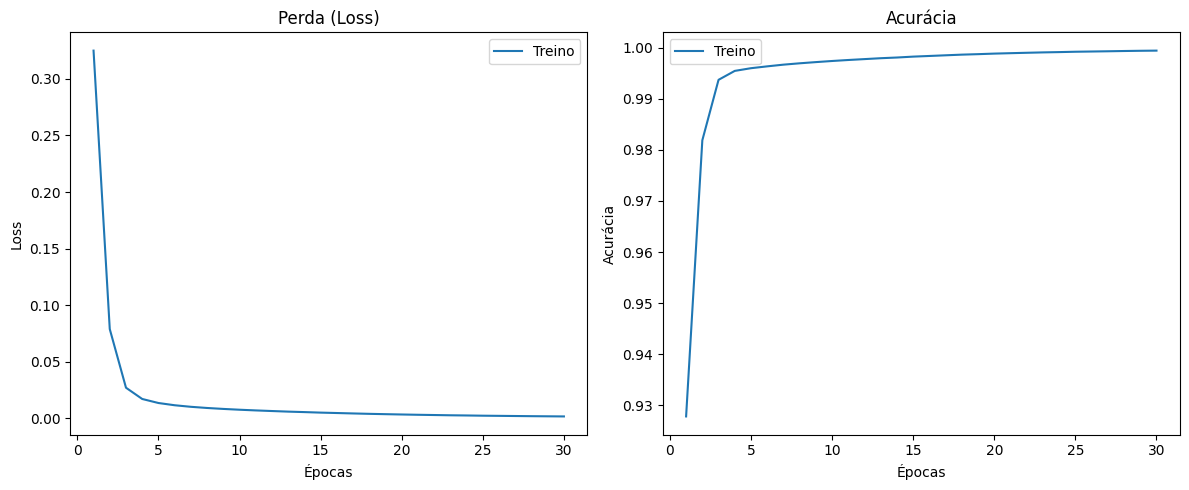

In [ ]:
import matplotlib.pyplot as plt

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, hist['loss'], label='Treino')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
if 'accuracy' in hist:
    plt.plot(epochs, hist['accuracy'], label='Treino')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow.keras as keras

In [ ]:
model.save("lstm_postagger.h5")

AttributeError: module 'tensorflow.keras' has no attribute 'save_model'

# Load model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("lstm_postagger.h5")

In [ ]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x78116ef3d910>

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 249, 64)        │     2,468,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 249, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 249, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 249, 46)        │         2,990 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,613,708 (29.04 MB)

 Trainable params: 2,537,902 (9.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,075,806 (19.36 MB)

## Predict

In [ ]:
path = "/content/drive/MyDrive/.../Penn Treebank/Penn Treebank/Secs22-24 - testing" #Ju

In [ ]:
sentences_test = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_test.extend(pt)

In [ ]:
sentences_dataset_spplited = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        sentences_dataset_spplited.extend([pt])

In [ ]:
import numpy as np

In [ ]:
def predict_tags(model, sentences, word2idx, idx2tag):
    # Extrair só as palavras da sentença
    words = [w for w, _ in sentences]

    # Converter as palavras para índices
    word_ids = [word2idx.get(w.lower(), word2idx['<UNK>']) for w in words]

    # Fazer padding
    padded = tf.keras.preprocessing.sequence.pad_sequences([word_ids], maxlen=max_len, padding='post')
    padded = tf.convert_to_tensor(padded, dtype=tf.int32)

    # Prever
    pred = model.predict(padded)[0]
    pred_tags = [idx2tag[np.argmax(p)] for p in pred[:len(words)]]

    return list(zip(words, pred_tags))


Never run the cell bellow with all the sentences_text list. Because dataset's test has about 130k data.

In [ ]:
y_true = []
y_pred = []

for sentence in sentences_dataset_spplited[:1000]:  # Cada item é uma frase: [('The', 'DT'), ('cat', 'NN'), ...]
    true_tags = [tag for _, tag in sentence]
    predicted_tags = [tag for _, tag in predict_tags(model, sentence, word2idx, idx2tag)]

    y_true.extend(true_tags)
    y_pred.extend(predicted_tags)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

In [ ]:
len(y_true)
len(y_pred)

249

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#print(classification_report(y_true, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 macro:", f1_score(y_true, y_pred, average='macro'))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

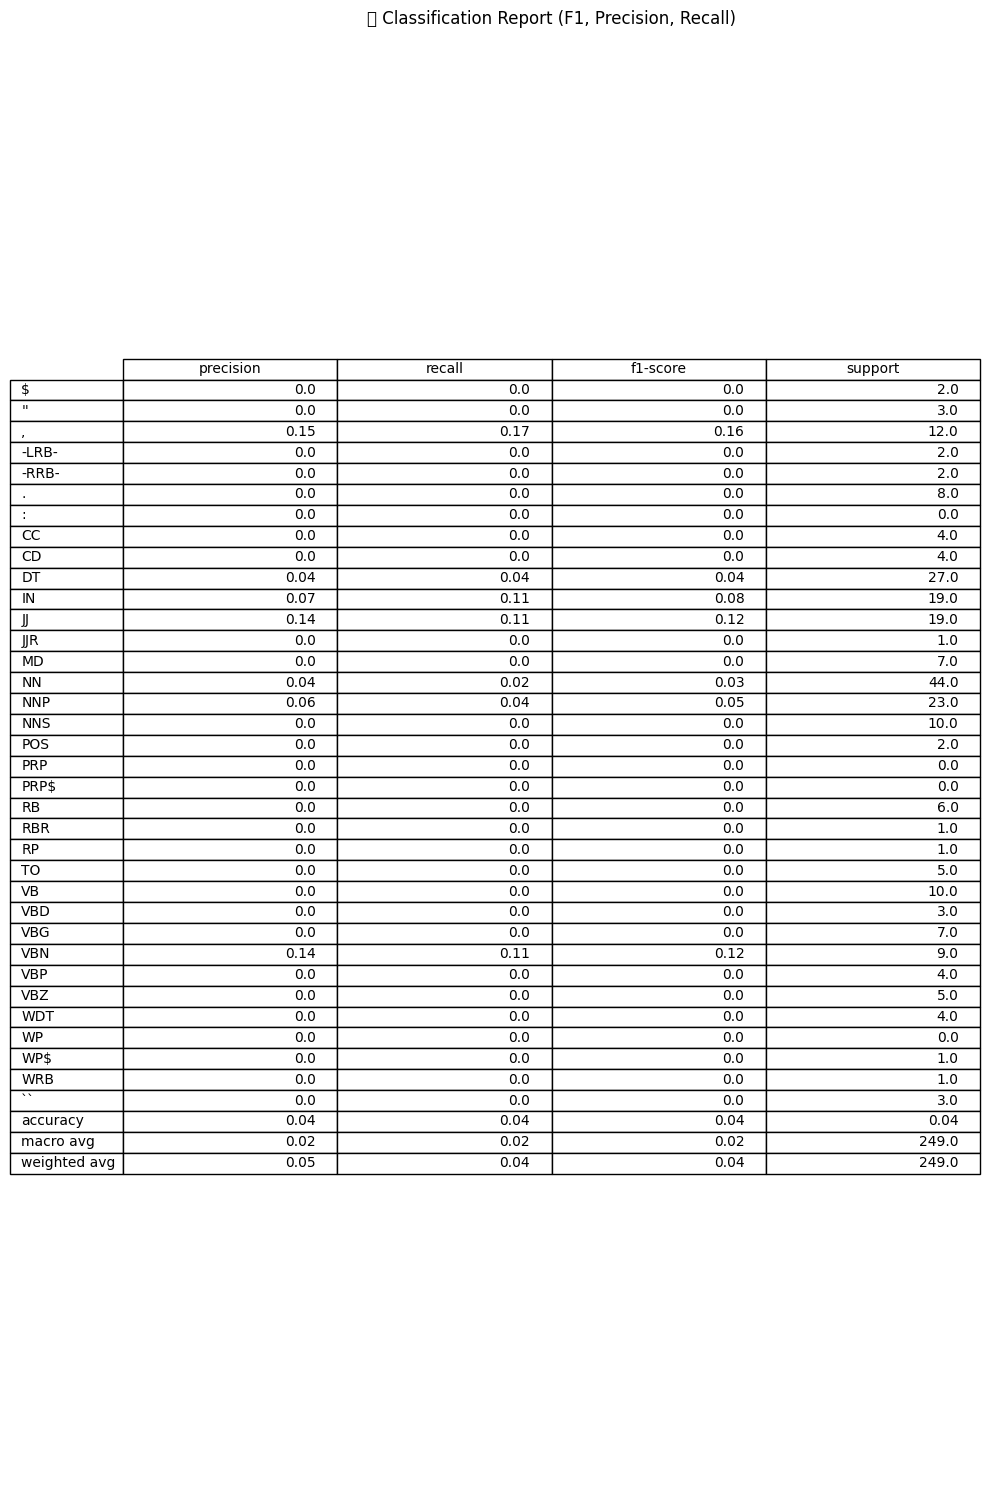

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred, digits=4, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

fig, ax = plt.subplots(figsize=(10, len(df_report) * 0.4))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_report.round(2).values,
         colLabels=df_report.columns,
         rowLabels=df_report.index,
         loc='center')
plt.title("📊 Classification Report (F1, Precision, Recall)")
plt.tight_layout()
plt.show()




/tmp/ipython-input-50-1207889945.py:7: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


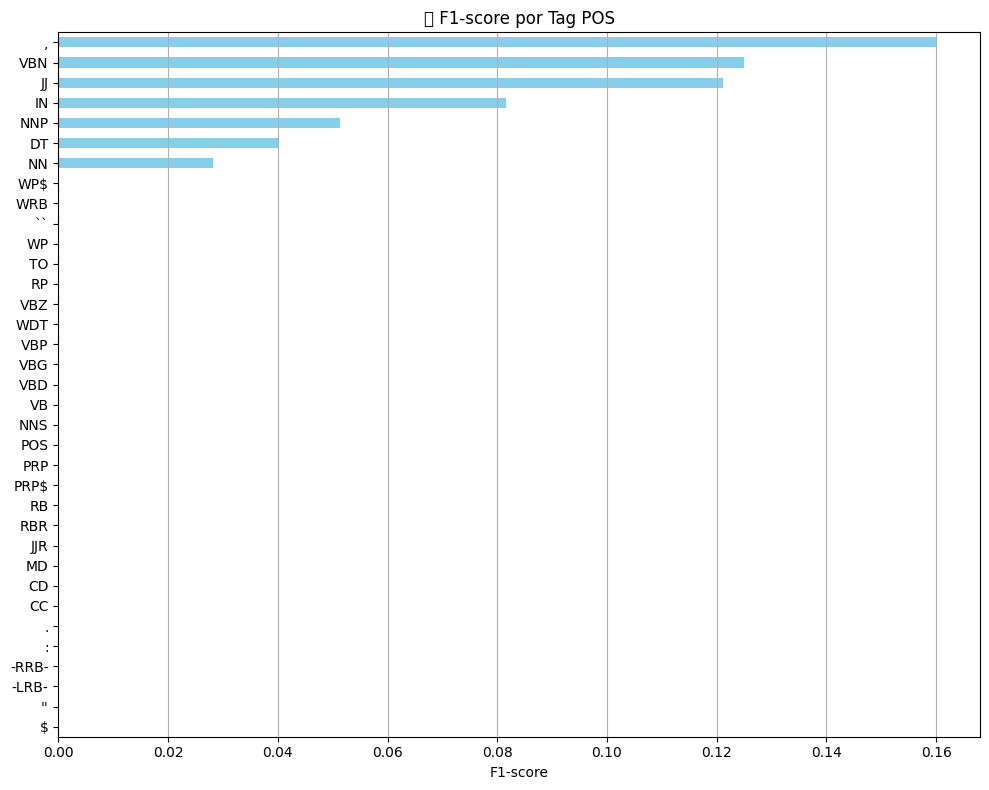

In [ ]:
f1_per_class = df_report.loc[df_report.index.str.len() <= 5].drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')['f1-score']

f1_per_class.sort_values().plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel("F1-score")
plt.title("📌 F1-score por Tag POS")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


/tmp/ipython-input-52-489268921.py:13: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


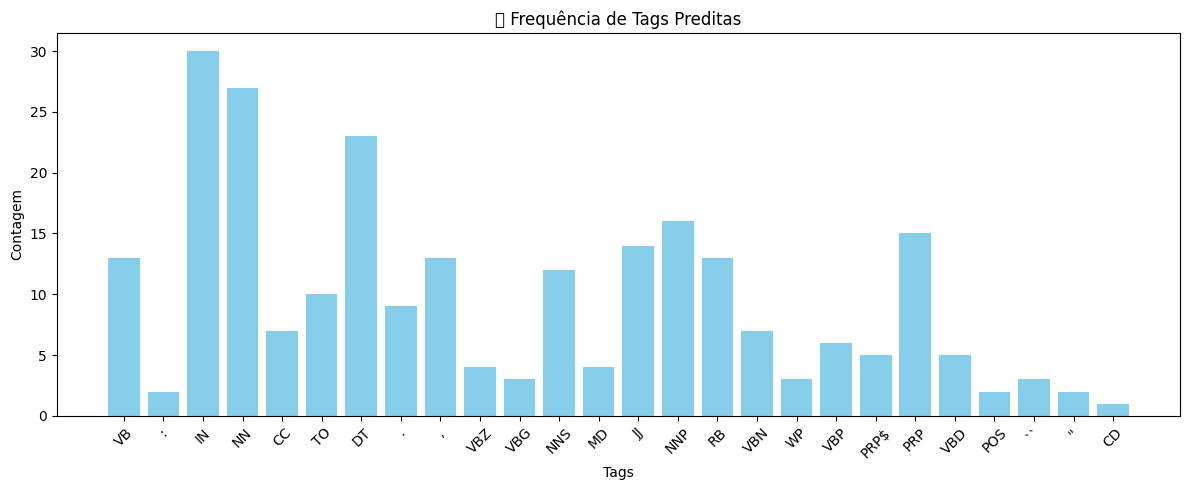

In [ ]:
from collections import Counter

# Conta as tags preditas
tag_counts = Counter(y_pred)

# Plota gráfico de barras
plt.figure(figsize=(12, 5))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.title("📌 Frequência de Tags Preditas")
plt.xlabel("Tags")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-53-2512374719.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


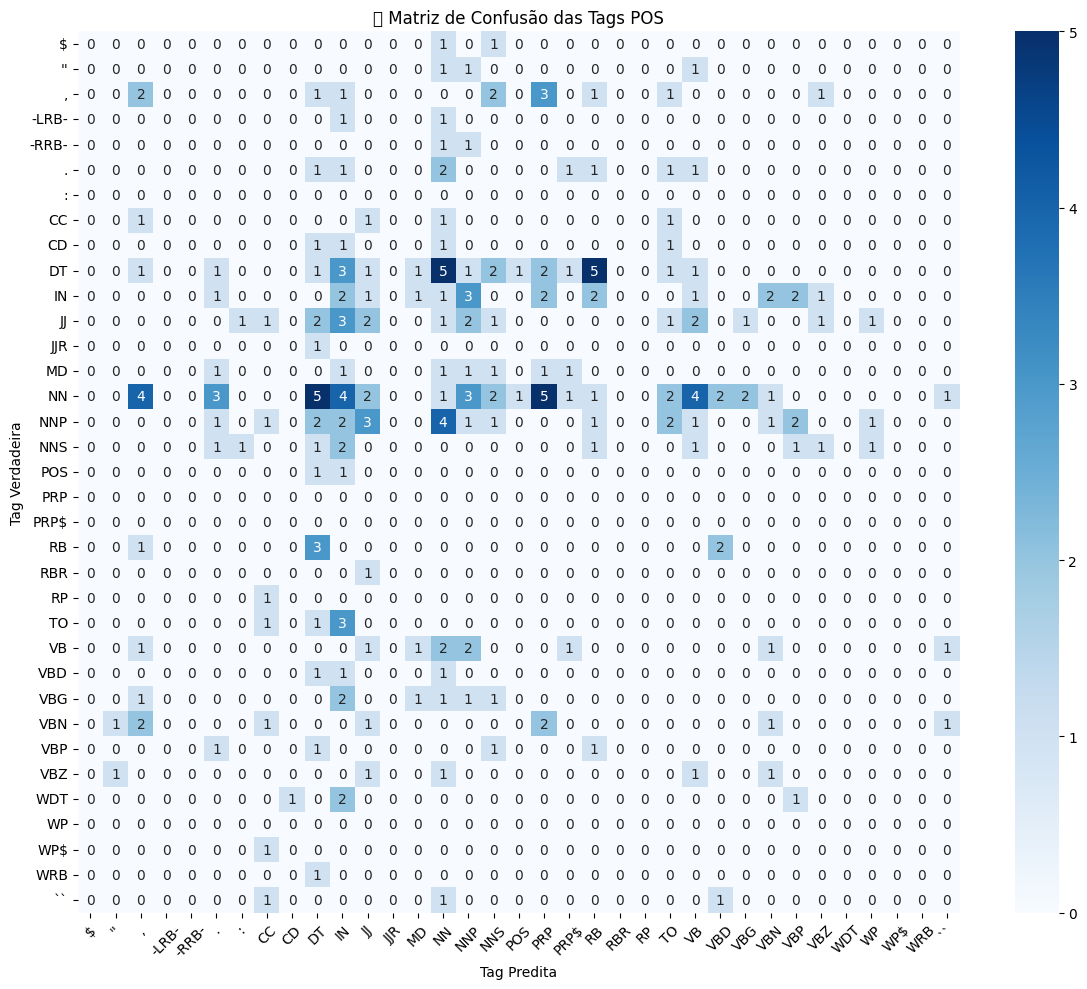

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cria matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true + y_pred)))

# Nomes das tags
labels = sorted(set(y_true + y_pred))

# Plot usando seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Tag Predita")
plt.ylabel("Tag Verdadeira")
plt.title("📊 Matriz de Confusão das Tags POS")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
